In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from tqdm import tqdm
import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)
path = "gdrive/MyDrive/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
df = pd.read_csv(path+"mov_gen_text.csv")
df.head(5)

,Unnamed: 0,imdbId,Genre,Title,Image_Paths,Plot
0,0,112854,Crime|Comedy|Fantasy,Destiny Turns on the Radio,gdrive/MyDrive/Posters/112854.jpg,Johnny Destiny burns into Las Vegas in his hot...
1,1,109642,Crime|Drama|Mystery,Dolores Claiborne,gdrive/MyDrive/Posters/109642.jpg,A big-city reporter travels to the small town ...
2,2,109686,Comedy,Dumb & Dumber,gdrive/MyDrive/Posters/109686.jpg,Harry and Lloyd are two good friends who happe...
3,3,111797,Comedy|Drama|Romance,Eat Drink Man Woman,gdrive/MyDrive/Posters/111797.jpg,Senior Master Chef Chu lives in a large house ...
4,4,109759,Drama,Exotica,gdrive/MyDrive/Posters/109759.jpg,This psychological thriller is true to its sub...


In [ ]:
print('Shape of data: ', df.shape)

Shape of data:  (3916, 6)


In [ ]:
#Firstly convert all the genre feature set into categorical types
df = df.drop(['imdbId','Unnamed: 0','Image_Paths'],axis = 1)
#df.columns
df.head(5)

,Genre,Title,Plot
0,Crime|Comedy|Fantasy,Destiny Turns on the Radio,Johnny Destiny burns into Las Vegas in his hot...
1,Crime|Drama|Mystery,Dolores Claiborne,A big-city reporter travels to the small town ...
2,Comedy,Dumb & Dumber,Harry and Lloyd are two good friends who happe...
3,Comedy|Drama|Romance,Eat Drink Man Woman,Senior Master Chef Chu lives in a large house ...
4,Drama,Exotica,This psychological thriller is true to its sub...


In [ ]:
def find_genres(genre):
    
    start = 0
    set_of_genre = []
    for i in range(len(genre)):
        
        k=0
        substring = ""
        if (genre[i]=='|'):
            substring = genre[start:i]
            start = i+1
            k = 1
        
        if(i==len(genre)-1):
            substring = genre[start:i+1]
            k = 1
            
        if (k==1):
            set_of_genre.append(substring)         
    
    return (set_of_genre)

In [ ]:
all_genre = []
Genre_list = df['Genre']

for i in range (len(Genre_list)):
    
    set_of_genre = find_genres(Genre_list[i])
    
    for j in range (len(set_of_genre)):
        all_genre.append(set_of_genre[j])
        
uniq, counts = np.unique(all_genre, return_counts=True)
print("Number of unique genres:", len(uniq))
print("Unique genres are:", uniq)
dict(zip(uniq, counts))

Number of unique genres: 22
Unique genres are: ['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Family' 'Fantasy' 'History' 'Horror' 'Music'
 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Short' 'Sport' 'Thriller' 'War'
 'Western']


{'Action': 747,
 'Adventure': 605,
 'Animation': 235,
 'Biography': 246,
 'Comedy': 1633,
 'Crime': 712,
 'Documentary': 221,
 'Drama': 2068,
 'Family': 298,
 'Fantasy': 295,
 'History': 131,
 'Horror': 312,
 'Music': 168,
 'Musical': 23,
 'Mystery': 283,
 'Romance': 808,
 'Sci-Fi': 228,
 'Short': 25,
 'Sport': 113,
 'Thriller': 503,
 'War': 81,
 'Western': 17}

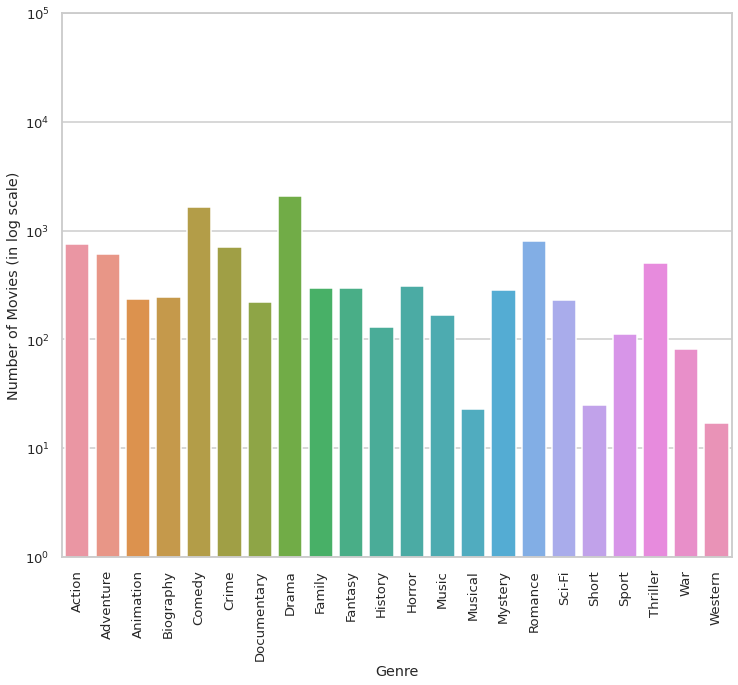

In [ ]:
df_movies_per_genre = pd.DataFrame({'Genre':uniq, 'Total': counts})
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', axes=ax)
ax.set(yscale='log', ylim=(1, 1e5), ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Prepare multi-hot-encoded-labels for the various genres
def multi_hot_encoded_labels(title,plot,genre):
    
    col_names =  ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Short','Sport','Thriller','War','Western']
    
    set_of_genre = find_genres(genre)
    
    row=[]
    row.append(title)
    row.append(plot)
    for i in range(len(col_names)):
        
        found = 0
        for j in range (len(set_of_genre)):
            if (set_of_genre[j]==col_names[i]):
                found = 1
                break
        
        row.append(found)
    
   #add the overall combined genre for record purposes
        
    return row  

In [ ]:
# Perform the encoding of the labels and save data in the format :
# Img-ID <multi-hot-encoded-labels> overall_genre
from tqdm import tqdm
#df = pd.read_csv("gdrive/MyDrive/"+"MovieGenre_final.csv",encoding="ISO-8859-1")
all_data = []

for index, row in tqdm(df.iterrows()):
    
    title = str(row['Title'])
    plot = str(row['Plot'])
    genre = row['Genre']
    row = multi_hot_encoded_labels(title,plot,genre)
    all_data.append(row)

col_names = ['Title','Plot','Action','Adventure','Animation','Biography','Comedy','Crime','Documentary','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Short','Sport','Thriller','War','Western']
    

df1 = pd.DataFrame(all_data,columns=col_names)
print("Shape of data is ",df1.shape)
df1.to_csv(path+"movie_plot_dataset.csv")
df1.head(5)


3916it [00:00, 7394.53it/s]


Shape of data is  (3916, 24)


,Title,Plot,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Destiny Turns on the Radio,Johnny Destiny burns into Las Vegas in his hot...,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Dolores Claiborne,A big-city reporter travels to the small town ...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Dumb & Dumber,Harry and Lloyd are two good friends who happe...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Eat Drink Man Woman,Senior Master Chef Chu lives in a large house ...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Exotica,This psychological thriller is true to its sub...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mydata = pd.read_csv(path+"movie_plot_dataset.csv",index_col=[0])
mydata.head(5)

,Title,Plot,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Destiny Turns on the Radio,Johnny Destiny burns into Las Vegas in his hot...,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Dolores Claiborne,A big-city reporter travels to the small town ...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Dumb & Dumber,Harry and Lloyd are two good friends who happe...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Eat Drink Man Woman,Senior Master Chef Chu lives in a large house ...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Exotica,This psychological thriller is true to its sub...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mydata.info

<bound method DataFrame.info of                                Title  ... Western
0         Destiny Turns on the Radio  ...       0
1                  Dolores Claiborne  ...       0
2                      Dumb & Dumber  ...       0
3                Eat Drink Man Woman  ...       0
4                            Exotica  ...       0
...                              ...  ...     ...
3911                     Miles Ahead  ...       0
3912                          Demons  ...       0
3913                  The Video Dead  ...       0
3914            The Legend of Tarzan  ...       0
3915  The Last Brickmaker in America  ...       0

[3916 rows x 24 columns]>

In [ ]:
#Firstly convert all the genre feature set into categorical types

category_columns = mydata.columns.drop(['Title', 'Plot'])
for col in category_columns:
    mydata[col] = mydata[col].astype('category')

In [ ]:
#Data Preprocessing

In [ ]:
#Remove punctuations
def remove_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    cleaned_sentence = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace("\n"," ")
    return cleaned_sentence

In [ ]:
#remove html tags
def remove_tags(sentence):
    html_tag = '<.*?>'
    cleaned_sentence = re.sub(html_tag, ' ',  sentence)
    return cleaned_sentence

In [ ]:
#removing accented charachters
def remove_accents(sentence):
    cleaned_sentence = unicodedata.normalize('NFD', sentence)
    cleaned_sentence = cleaned_sentence.encode('ascii', 'ignore')
    cleaned_sentence = cleaned_sentence.decode("utf-8")
    return cleaned_sentence

In [ ]:
#removing numbers 
def keep_alpha(sentence):
    alpha_sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    return alpha_sentence

In [ ]:
#text lowercase
def lower_case(sentence):
    lower_case_sentence = sentence.lower()
    return lower_case_sentence

In [ ]:
def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence=' '.join(stemmed_words)
    return stemmed_sentence

In [ ]:
def lemmatize_words(sentence):
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, 'v') for word in sentence.split()]
    lemmatized_sentence=' '.join(lemmatized_words)
    return lemmatized_sentence

In [ ]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                       'may','also','across','among','beside','however','yet','within'])
    no_stop_words=[word for word in sentence.split() if word not in stop_words]
    no_step_sentence = ' '.join(no_stop_words)
    return no_step_sentence

In [ ]:
def text_preprocess(sentence):
    pre_processed_sentence = remove_tags(sentence)
    pre_processed_sentence = remove_accents(pre_processed_sentence)
    pre_processed_sentence = remove_punctuation(pre_processed_sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    #pre_processed_sentence = stemming(pre_processed_sentence) # Use Lemmatize instead of stemming
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    
    return pre_processed_sentence

In [ ]:
mydata['Plot'] = mydata['Plot'].apply(text_preprocess)
mydata.to_csv(path+'text/movies_genres_text_preprocessed.csv', index=False)
path=path+'text/'
mydata.head(5)

,Title,Plot,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Destiny Turns on the Radio,johnny destiny burn las vegas hot plymouth roa...,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Dolores Claiborne,big city reporter travel small town mother arr...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Dumb & Dumber,harry lloyd good friends happen really stupid ...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Eat Drink Man Woman,senior master chef chu live large house taipei...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Exotica,psychological thriller true subject well compl...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
fig = plt.figure(figsize=(18, 70))
num_cols = 2
num_rows = math.ceil(len(category_columns)/num_cols)
for idx, col in enumerate(category_columns):
    wordcloud = WordCloud(max_font_size=50).generate(' '.join(mydata[mydata[col]==1]['Plot']))
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set(title='Movie Genre: {0}'.format(col))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

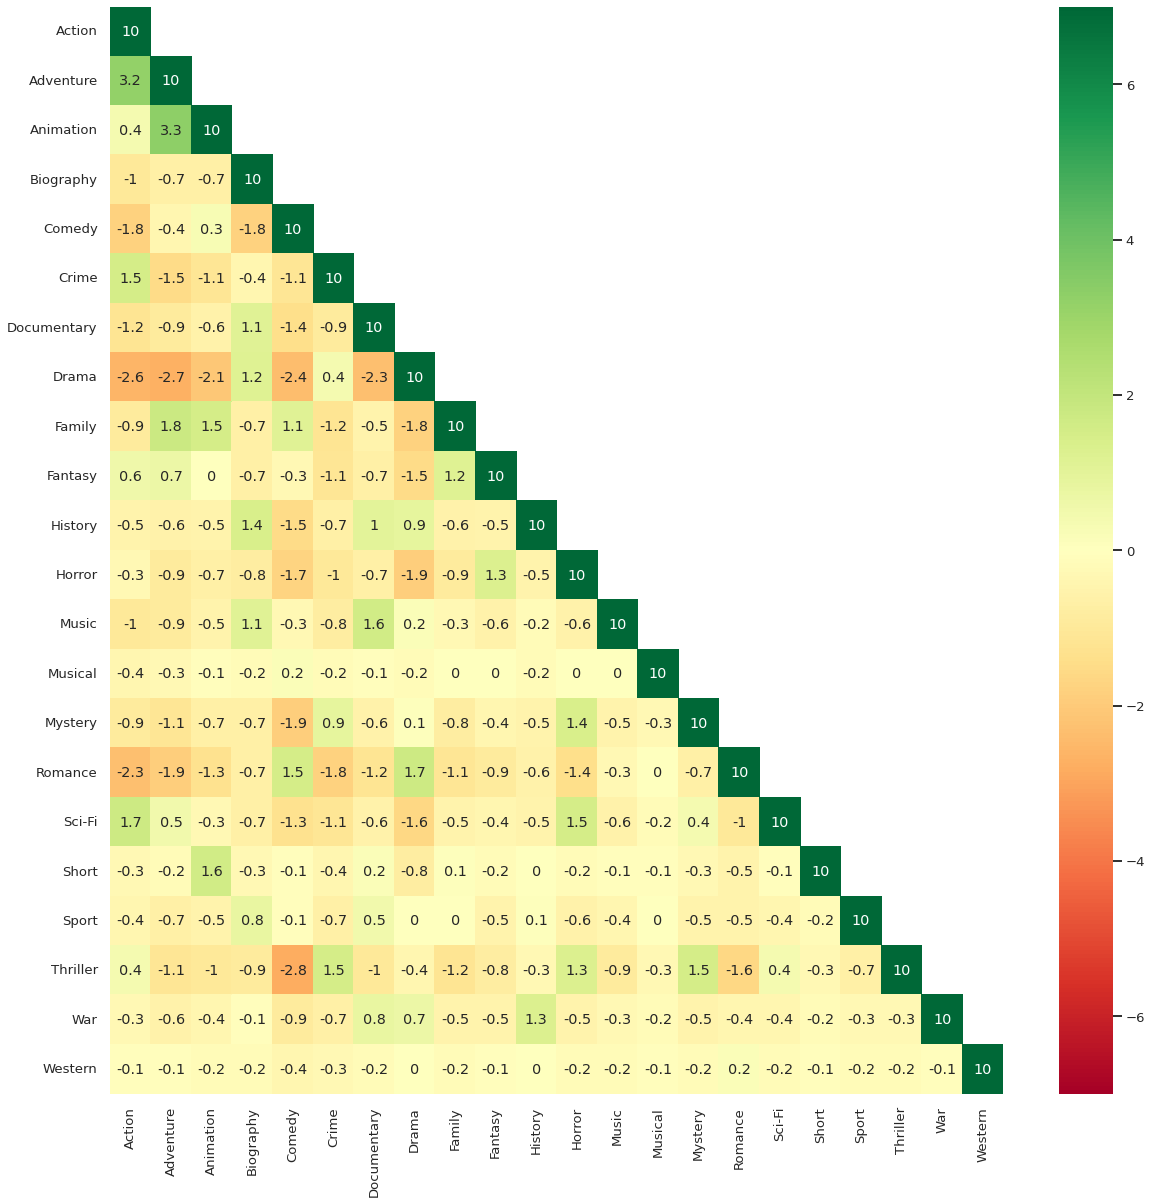

In [ ]:
# Heatmap relative to all numeric columns
corr_matrix = (mydata[category_columns].astype('int')).corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
corr_matrix = (100*corr_matrix//1)/10

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=7, vmin=-7, cmap='RdYlGn')
plt.show()

In [ ]:
path='gdrive/MyDrive/text/'
train_df = mydata.sample(frac=0.80, random_state=50) #Taking 80% of the data
test_df = mydata.drop(train_df.index)
print(train_df.shape)
print(test_df.shape)
#train_df.to_csv(path+'train_text.csv')
#test_df.to_csv(path+'test_text.csv')
train_df.head(5)


NameError: ignored

In [ ]:
path='gdrive/MyDrive/text/'
train_df = pd.read_csv(path+'train_text.csv',index_col=[0])
test_df = pd.read_csv(path+'test_text.csv',index_col=[0])
train_X, train_y = train_df['Plot'], train_df.drop(['Title', 'Plot'], axis=1)
test_X, test_y = test_df['Plot'], test_df.drop(['Title', 'Plot'], axis=1)

category_columns = train_y.columns
train_df.head(5)

,Title,Plot,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
793,Love Walked In,luck piano player denis leary blue cat lounge ...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3566,Seven Pounds,haunt secret ben thomas look redemption radica...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1692,Rock Star,chris cole bear rock longtime girlfriend emily...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3049,"You, Me and Dupree",newlyweds carl molly peterson life cant get sw...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2534,Mr 3000,stan ross baseball superstar turn back game ye...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer,fbeta_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

from helper_functions import *


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [ ]:
train_X.head(5)

793     luck piano player denis leary blue cat lounge ...
3566    haunt secret ben thomas look redemption radica...
1692    chris cole bear rock longtime girlfriend emily...
3049    newlyweds carl molly peterson life cant get sw...
2534    stan ross baseball superstar turn back game ye...
Name: Plot, dtype: object

In [ ]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [ ]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(train_X)
xval_tfidf = tfidf_vectorizer.transform(test_X)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [ ]:
# fit model on train data
clf.fit(xtrain_tfidf, train_y)

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
y_pred = clf.predict(xval_tfidf)

In [ ]:
# evaluate performance
f1_score(test_y, y_pred, average="micro")

0.4067921742340347

In [ ]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [ ]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

TypeError: ignored

In [ ]:
# evaluate performance
f1_score(test_y, y_pred_new, average="micro")

0.5205627705627706

In [3]:
algo_score = pd.DataFrame()
algo_score.index.name = 'Type of data'
algo_score['Overall Precision'] = None

In [4]:
algo_score.loc['Posters'] = [0.84]
algo_score.loc['Plots'] = [0.52]

In [5]:
algo_score

,Overall Precision
Modelling Algo,
From Posters,0.84
From Plots,0.52


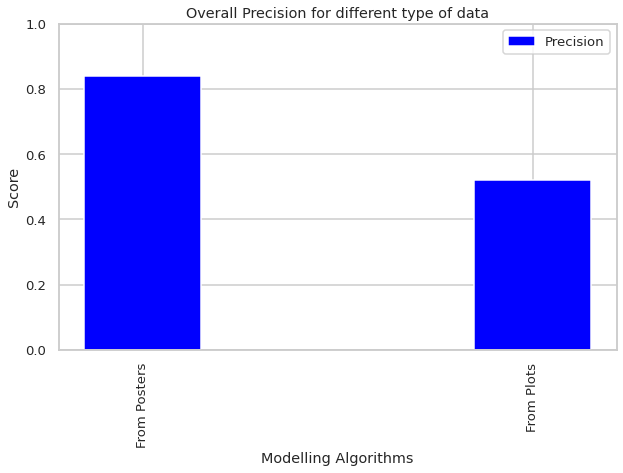

In [6]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.3
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Overall Precision', x=idx, color='b', width=bar_width, label='Precision')
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('Score')
plt.ylim((0, 1))
plt.title('Overall Precision for different type of data')
plt.legend()
plt.show()